In [1]:
# %load wgan_div.py
import argparse
import os
import numpy as np
import math
import sys

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch

In [3]:
os.makedirs("images", exist_ok=True)

In [2]:
n_epochs = 200
batch_size = 64
lr = 0.0002
b1 = 0.5
b2 = 0.999
n_cpu = 8
latent_dim = 100
img_size = 28
channels = 1
n_critic = 5
clip_value = 0.01
sample_interval = 400

In [3]:
img_shape = (channels, img_size, img_size)

cuda = True if torch.cuda.is_available() else False


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity


k = 2
p = 6


# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()

# Configure data loader
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [4]:
# ----------
#  Training
# ----------
from IPython.display import clear_output

G_loss_history = []
D_loss_history = []

batches_done = 0
for epoch in range(n_epochs):
    G_batch_loss = 0
    D_batch_loss = 0
    for i, (imgs, _) in enumerate(dataloader):

        # Configure input
        real_imgs = Variable(imgs.type(Tensor), requires_grad=True)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

        # Generate a batch of images
        fake_imgs = generator(z)

        # Real images
        real_validity = discriminator(real_imgs)
        # Fake images
        fake_validity = discriminator(fake_imgs)

        # Compute W-div gradient penalty
        real_grad_out = Variable(Tensor(real_imgs.size(0), 1).fill_(1.0), requires_grad=False)
        real_grad = autograd.grad(
            real_validity, real_imgs, real_grad_out, create_graph=True, retain_graph=True, only_inputs=True
        )[0]
        real_grad_norm = real_grad.view(real_grad.size(0), -1).pow(2).sum(1) ** (p / 2)

        fake_grad_out = Variable(Tensor(fake_imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake_grad = autograd.grad(
            fake_validity, fake_imgs, fake_grad_out, create_graph=True, retain_graph=True, only_inputs=True
        )[0]
        fake_grad_norm = fake_grad.view(fake_grad.size(0), -1).pow(2).sum(1) ** (p / 2)

        div_gp = torch.mean(real_grad_norm + fake_grad_norm) * k / 2

        # Adversarial loss
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + div_gp

        d_loss.backward()
        optimizer_D.step()

        D_batch_loss += d_loss.item()
        
        optimizer_G.zero_grad()

        # Train the generator every n_critic steps
        if i % n_critic == 0:

            # -----------------
            #  Train Generator
            # -----------------

            # Generate a batch of images
            fake_imgs = generator(z)
            # Loss measures generator's ability to fool the discriminator
            # Train on fake images
            fake_validity = discriminator(fake_imgs)
            g_loss = -torch.mean(fake_validity)

            g_loss.backward()
            optimizer_G.step()
            
            G_batch_loss += g_loss.item()

            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
            )

            if batches_done % sample_interval == 0:
                save_image(fake_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)

            batches_done += n_critic
    n = len(dataloader) / n_critic
    G_loss_history.append(G_batch_loss / n)
    D_loss_history.append(D_batch_loss / len(dataloader))
    if epoch % 10 == 0:
        clear_output()

[Epoch 191/200] [Batch 0/938] [D loss: -0.188629] [G loss: -0.672247]
[Epoch 191/200] [Batch 5/938] [D loss: -0.435082] [G loss: -0.598661]
[Epoch 191/200] [Batch 10/938] [D loss: -0.566684] [G loss: -0.435395]
[Epoch 191/200] [Batch 15/938] [D loss: -0.324721] [G loss: -0.609361]
[Epoch 191/200] [Batch 20/938] [D loss: -0.434399] [G loss: -0.497636]
[Epoch 191/200] [Batch 25/938] [D loss: -0.335965] [G loss: -0.604987]
[Epoch 191/200] [Batch 30/938] [D loss: -0.329710] [G loss: -0.585876]
[Epoch 191/200] [Batch 35/938] [D loss: -0.320601] [G loss: -0.421540]
[Epoch 191/200] [Batch 40/938] [D loss: -0.448085] [G loss: -0.493913]
[Epoch 191/200] [Batch 45/938] [D loss: -0.308799] [G loss: -0.584525]
[Epoch 191/200] [Batch 50/938] [D loss: -0.263444] [G loss: -0.565747]
[Epoch 191/200] [Batch 55/938] [D loss: -0.485669] [G loss: -0.331294]
[Epoch 191/200] [Batch 60/938] [D loss: -0.279591] [G loss: -0.708598]
[Epoch 191/200] [Batch 65/938] [D loss: -0.295986] [G loss: -0.800018]
[Epoch 1

In [4]:
generator.load_state_dict(torch.load('wgan_div_generator.pt'))

<All keys matched successfully>

# 用train好的generator產生64張圖片

產生64個100維的latent space

In [5]:
pic_num = 64
latent_space = np.random.normal(0, 1, (pic_num, latent_dim))

將圖片轉成(H,W,C)並畫出來

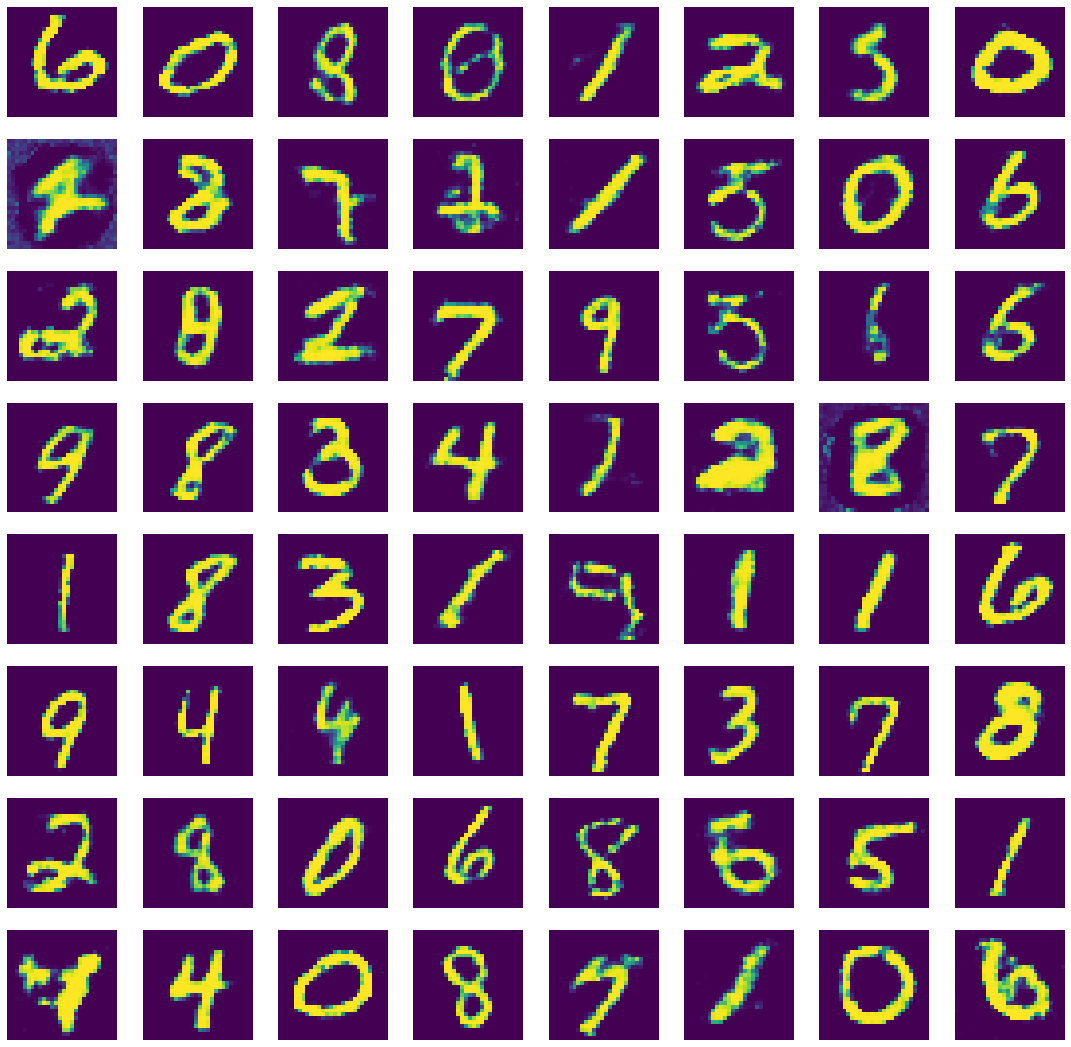

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(19, 19))
for i in range(pic_num):
    plt.subplot(8,8,i+1)
    plt.imshow(generator(Variable(Tensor(latent_space))).detach().view(pic_num, 28, 28, 1)[i].to('cpu'))
    plt.axis('off')

# 畫出Loss

Generator loss:

Text(0.5, 0, 'epochs')

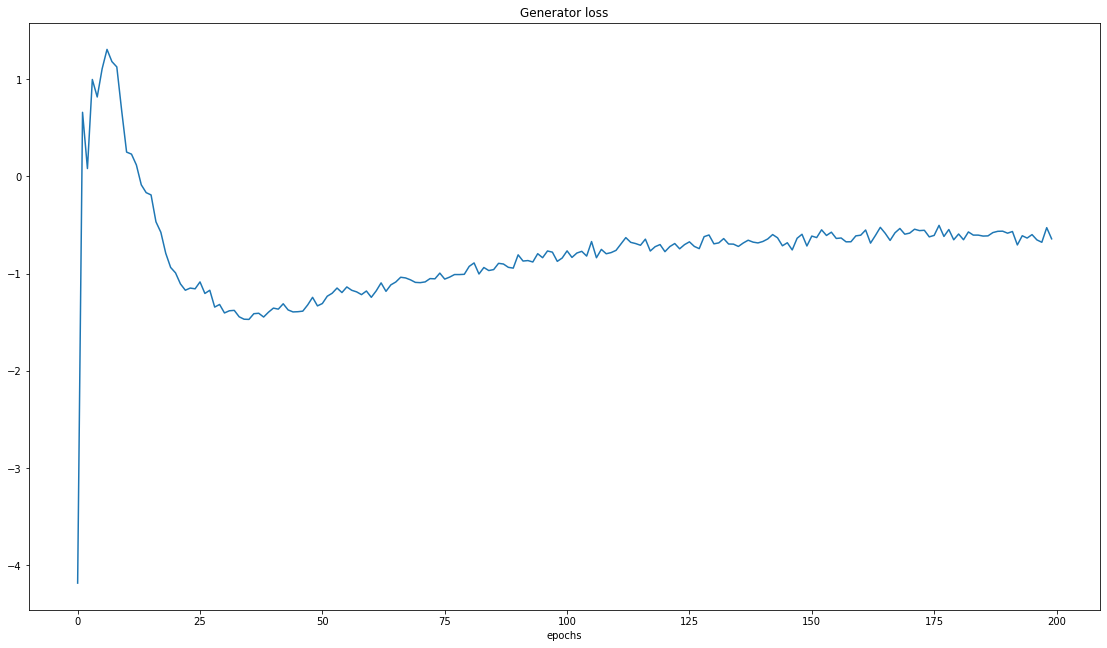

In [12]:
plt.figure(figsize=(19.2, 10.8))
plt.title('Generator loss')
x = np.arange(len(G_loss_history))
plt.plot(x, G_loss_history)
plt.xlabel('epochs')

Discriminator loss

Text(0.5, 0, 'epochs')

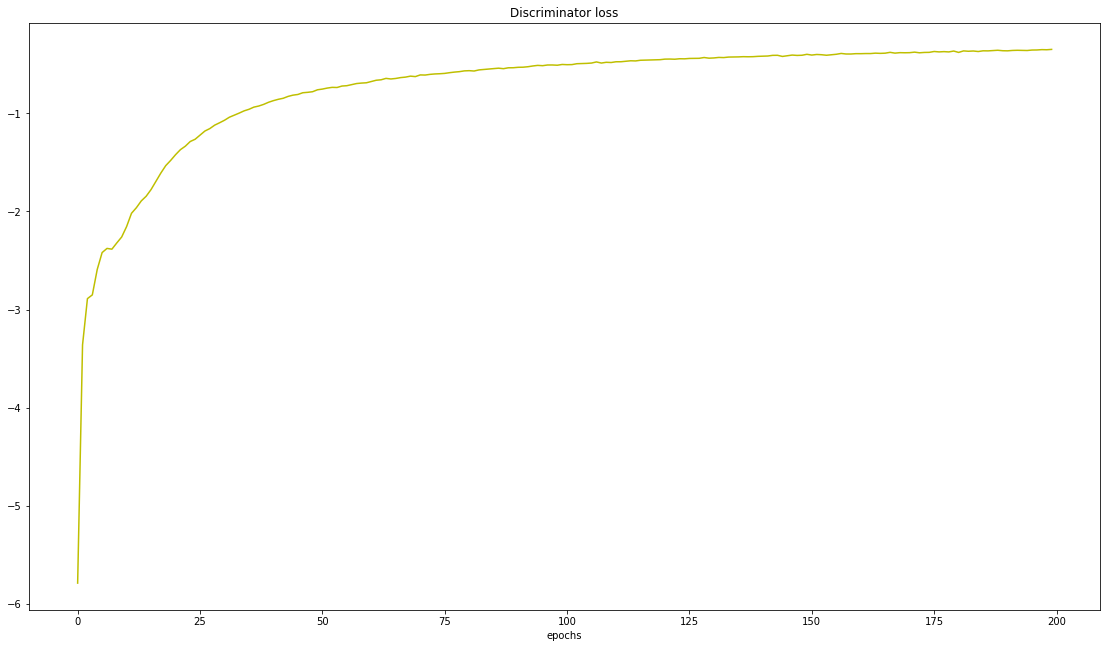

In [13]:
plt.figure(figsize=(19.2, 10.8))
plt.title('Discriminator loss')
x = np.arange(len(D_loss_history))
plt.plot(x, D_loss_history, 'y')
plt.xlabel('epochs')

In [9]:
torch.save(generator.state_dict(),'wgan_div_generator.pt')
torch.save(discriminator.state_dict(), 'wgan_div_discriminator.pt')

# 將tensor轉成圖片

將generator產生的圖片存到指定路徑

In [5]:
pic_num = 50000
latent_space = torch.randn([pic_num, latent_dim], device='cuda')

In [6]:
generator.eval()

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)

In [7]:
with torch.no_grad():
    out = generator(latent_space)

In [8]:
from PIL import Image

In [9]:
imgs = np.clip(out.cpu().numpy() * 127.5 + 127.5, 0, 255).astype(np.uint8)

In [10]:
n = 0
for i in range(pic_num):
    Image.fromarray(imgs[i,0], mode='L').save('wgan_div_images/%d.png' % n)
    n+=1

# 計算兩組圖片之間的FID距離(越接近0代表兩者的分佈越接近，也就是圖片越像真實的圖片)

In [11]:
!python -m pytorch_fid --batch-size=64 --device=cuda:0 /home/ystsai/work/DeepLearning/lab5/mnist_images/ /home/ystsai/work/DeepLearning/lab5/wgan_div_images/

100%|█████████████████████████████████████████| 782/782 [00:46<00:00, 16.95it/s]
FID:  22.184456346607192
